# Crypto Trading strategies & Transfer learning - ML/DL project


- **Arian NAJAFY ABRANDABADY - Lucas RODRIGUEZ - Bastien TRIDON**
- *Academic works (March - April 2023)*

**Original dataset**:
- https://www.kaggle.com/competitions/g-research-crypto-forecasting

First, please check your project architecture:

```
.
├── README.md
├── data
│   ├── asset_details.csv
│   ├── example_test.csv
│   ├── supplemental_train.csv
│   └── train.csv
├── main.ipynb
└── requirements.txt
```

Then, please make sure you have installed each dependency:

In [329]:
# Un-comment this cell and run it
#!pip3 install -r requirements.txt

# Pre-processing

<span style="color:red">**WARNING**: The `tablib` module requires an additional dependency. Please refer to the official [documentation](https://ta-lib.github.io/ta-lib-python/install.html).</span>

In [330]:
# Importing necessary modules
import pandas as pd
import numpy as np
import glob
import warnings
import scikitplot as skplt
import matplotlib
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
import talib as tl
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (precision_recall_curve,
                             plot_precision_recall_curve,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             roc_auc_score)

# Plotting options
#matplotlib.use("nbagg")
#from plotly.offline import init_notebook_mode, iplot
#from plotly.graph_objs import *
#import mplfinance as mpf
#init_notebook_mode(connected=True) 
#pd.options.plotting.backend = "plotly"

# Setting default parameters
plt.rcParams["figure.figsize"] = [12, 5] # Figure sizes for Matplotlib 
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["blue", "green", "red", "orange", "purple", "magenta"]) # Color for plotting

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

## Utils & Necessary functions

In [331]:
# Declaring the column labels
OHLC = ["Open", "High", "Low", "Close"]
OHLCV = OHLC + ["Volume"]
TRADING_ACTIVITY = ["Count"]
VWAP = ["VWAP"]
TARGET = ["Target"]

In [332]:
# Checking data filenames
DATA_FILENAMES = glob.glob("data/*.csv")
DATA_FILENAMES

['data/asset_details.csv',
 'data/supplemental_train.csv',
 'data/train.csv',
 'data/example_test.csv']

In [333]:
# Checking that we only have the 4 files
assert len(DATA_FILENAMES) == 4

In [334]:
# Importing and storing asset details
ASSET_DETAILS = pd.read_csv(filepath_or_buffer="data/asset_details.csv", index_col="Asset_ID")
ASSET_DETAILS.T

Asset_ID,2,0,1,5,7,6,9,11,13,12,3,8,10,4
Weight,2.397895,4.304065,6.779922,1.386294,2.079442,5.894403,2.397895,1.609438,1.791759,2.079442,4.406719,1.098612,1.098612,3.555348
Asset_Name,Bitcoin Cash,Binance Coin,Bitcoin,EOS.IO,Ethereum Classic,Ethereum,Litecoin,Monero,TRON,Stellar,Cardano,IOTA,Maker,Dogecoin


In [335]:
# Retrieving asset ids
ASSET_IDS = sorted(list(ASSET_DETAILS.index))
ASSET_IDS

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [336]:
# Declaring utils functions

def get_asset_id(asset_name: str) -> int:
    """
    Function returning the asset id from a given asset name
    """
    # Getting the list of asset names
    LIST_ASSET_NAMES = ASSET_DETAILS['Asset_Name'].to_numpy()
    
    # Checking if the asset name is correct
    if str(asset_name) not in LIST_ASSET_NAMES:
        raise Exception(f"The given asset name is unknown\nPlease use one from: {LIST_ASSET_NAMES}")
    
    # Returning the corresponding asset id
    return list(ASSET_DETAILS.index[ASSET_DETAILS["Asset_Name"] == str(asset_name)])[0]

def get_asset_name(asset_id: int) -> str:
    """
    Function returning the asset name from a given asset id
    """
    if int(asset_id) not in ASSET_IDS:
        raise Exception(f"The given asset id is unknown\nPlease use one from: {ASSET_IDS}")
    
    return ASSET_DETAILS["Asset_Name"][asset_id]

In [337]:
ASSET_NAMES = [str(get_asset_name(k)) for k in ASSET_IDS]
ASSET_NAMES

['Binance Coin',
 'Bitcoin',
 'Bitcoin Cash',
 'Cardano',
 'Dogecoin',
 'EOS.IO',
 'Ethereum',
 'Ethereum Classic',
 'IOTA',
 'Litecoin',
 'Maker',
 'Monero',
 'Stellar',
 'TRON']

In [338]:
# Example
get_asset_id("Bitcoin")

1

## Datasets imports (TRAIN/TEST)

**TRAIN/TRAIN_2 datasets**

In [339]:
# Importing training dataset
TRAIN = pd.read_csv(filepath_or_buffer="data/train.csv")

In [340]:
# Importing second training dataset
TRAIN_2 = pd.read_csv(filepath_or_buffer="data/supplemental_train.csv")

In [341]:
# Verify the continuity of the time series
#TRAIN.tail()
#TRAIN_2.head()

**TEST dataset**

In [342]:
# Importing test dataset
TEST = pd.read_csv(filepath_or_buffer="data/example_test.csv")
TEST.head()
TRAIN[TRAIN["timestamp"] == TEST.iloc[0]["timestamp"]].shape

# TODO: explanation

(14, 10)

**Comment**: The `TEST` table contains duplicate rows from the `TRAIN` table. It can be removed properly.

In [343]:
TRAIN.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [344]:
TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [345]:
TRAIN_2.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1632182460,3,561.0,2.079028,2.080605,2.0720,2.076458,2.804627e+05,2.075869,0.003085
1,1632182460,2,169.0,541.006000,541.200000,539.7000,540.722000,1.889432e+02,540.716930,-0.000607
2,1632182460,0,400.0,363.737500,363.900000,363.0000,363.654000,8.792685e+02,363.499554,-0.019375
3,1632182460,1,1933.0,42986.143333,43001.000000,42898.0000,42947.065566,9.183861e+01,42942.976718,-0.000374
4,1632182460,4,348.0,0.208326,0.208400,0.2078,0.208200,1.051337e+06,0.208077,-0.001233


In [346]:
TRAIN_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518278 entries, 0 to 2518277
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 192.1 MB


In [347]:
# Merging TRAIN and TRAIN_2 as df
df = pd.concat([TRAIN, TRAIN_2], axis = 0)

In [348]:
# Première date: 2018-01-01 00:01:00
# Dernière date: 2022-01-24 00:00:00

In [349]:
# Hashmap of train datasets for each asset id
df_dict = {asset_id: None for asset_id in ASSET_IDS}

# For each asset id, perform the pre-processing
for asset_id in ASSET_IDS:
    print(f"--> Processing Asset #{asset_id} \t ({get_asset_name(asset_id)})")
    
    # Retrieving the corresponding data rows
    df_dict[asset_id] = df[df["Asset_ID"] == asset_id]
    
    # Removing the Asset_ID column (useless now)
    try:
        df_dict[asset_id].drop(["Asset_ID", "Target"], axis=1, inplace=True)
    except:
        pass
    
    # Converting the timestamp column
    df_dict[asset_id]["timestamp"] = pd.to_datetime(arg=df_dict[asset_id]["timestamp"], 
                                                     unit="s", 
                                                     errors="ignore")
    # Setting the timestamp column as index column
    df_dict[asset_id].set_index(["timestamp"], inplace=True)

--> Processing Asset #0 	 (Binance Coin)
--> Processing Asset #1 	 (Bitcoin)
--> Processing Asset #2 	 (Bitcoin Cash)
--> Processing Asset #3 	 (Cardano)
--> Processing Asset #4 	 (Dogecoin)
--> Processing Asset #5 	 (EOS.IO)
--> Processing Asset #6 	 (Ethereum)
--> Processing Asset #7 	 (Ethereum Classic)
--> Processing Asset #8 	 (IOTA)
--> Processing Asset #9 	 (Litecoin)
--> Processing Asset #10 	 (Maker)
--> Processing Asset #11 	 (Monero)
--> Processing Asset #12 	 (Stellar)
--> Processing Asset #13 	 (TRON)


In [350]:
# Displaying a DataFrame
df_dict[get_asset_id("Bitcoin")]

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229.0,13835.194000,14013.8,13666.11,13850.176000,31.550062,13827.062093
2018-01-01 00:02:00,235.0,13835.036000,14052.3,13680.00,13828.102000,31.046432,13840.362591
2018-01-01 00:03:00,528.0,13823.900000,14000.4,13601.00,13801.314000,55.061820,13806.068014
2018-01-01 00:04:00,435.0,13802.512000,13999.0,13576.28,13768.040000,38.780529,13783.598101
2018-01-01 00:05:00,742.0,13766.000000,13955.9,13554.44,13724.914000,108.501637,13735.586842
...,...,...,...,...,...,...,...
2022-01-23 23:56:00,1221.0,36278.361667,36331.0,36249.00,36293.123333,30.247067,36289.796806
2022-01-23 23:57:00,1634.0,36289.681667,36328.0,36230.72,36261.708333,35.647000,36276.229399
2022-01-23 23:58:00,1570.0,36262.841667,36319.0,36230.30,36276.223333,49.867700,36274.441548


**Checking the loss of informations**

In [351]:
# Checking the sum of the number of rows for each asset id is equal to the number of rows from the original dataset
# ==> No loss
assert sum([df_dict[k].shape[0] for k in ASSET_IDS]) == df.shape[0]

**Checking the memory usage for each dataframe**

In [352]:
# Getting memory usage

# Computing the memory usage of each DataFrame
MEM_USAGE = {asset_id: df_dict[asset_id].memory_usage(index=True).sum()/10**6 for asset_id in ASSET_IDS}

# Computing the global memory usage
GLOBAL_MEM_USAGE = sum(list(MEM_USAGE.values()))/10**3
print(f"Global mem. usage: \t {GLOBAL_MEM_USAGE :.1f} GB")

Global mem. usage: 	 1.7 GB


## Data visualization & EDA

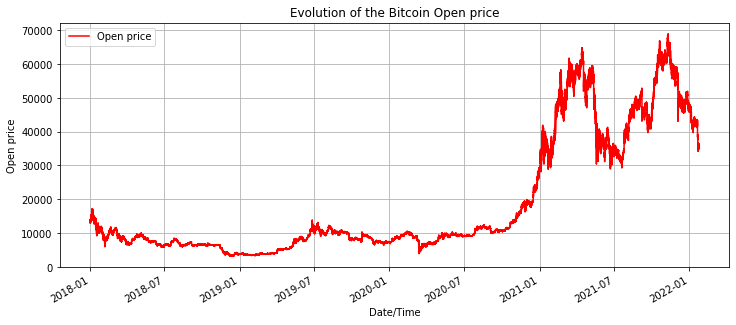

In [353]:
# Displaying a random dataframe (train)
_ = df_dict[get_asset_id("Bitcoin")]["Open"].plot(label="Open price", color="red")
_ = plt.grid()
_ = plt.title("Evolution of the Bitcoin Open price")
_ = plt.legend()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Open price")

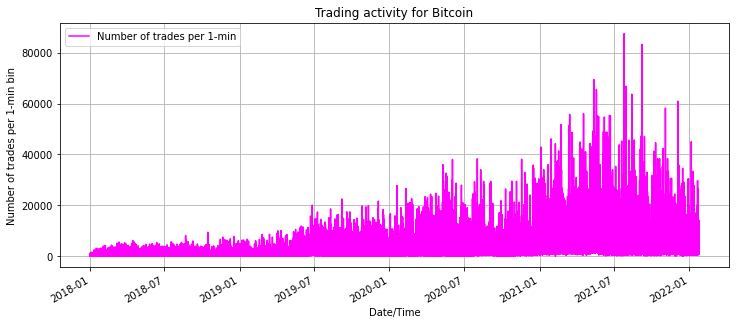

In [354]:
# Plotting trading activity
_ = df_dict[get_asset_id("Bitcoin")][TRADING_ACTIVITY].plot(color="magenta")
_ = plt.grid()
_ = plt.title("Trading activity for Bitcoin")
_ = plt.legend(["Number of trades per 1-min"])
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Number of trades per 1-min bin")

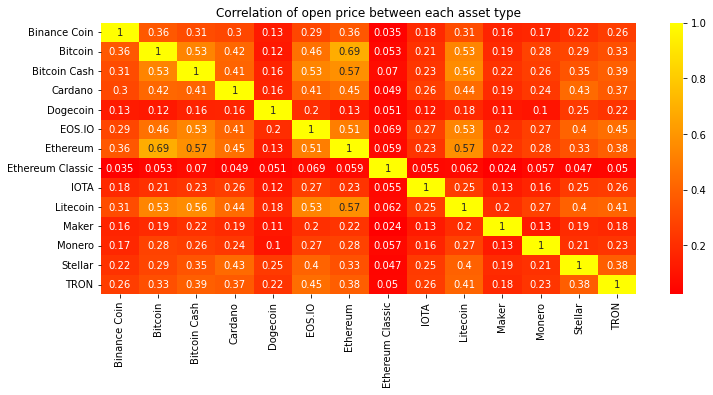

In [355]:
# Computing the correlation matrix of a given metric
X = pd.concat([df_dict[k]["Volume"] for k in ASSET_IDS], axis=1)
X.columns = ASSET_NAMES

# Plot this correlation matrix
_ = sns.heatmap(X.corr(), annot=True, cmap="autumn")
_ = plt.title("Correlation of open price between each asset type")

In [356]:
# Plot candlestick representation
"""
s = mpf.make_mpf_style(base_mpf_style="yahoo", rc={'font.size': 10})
fig = mpf.figure(figsize=(20, 15), style=s)
ax = fig.add_subplot(2,1,1)
mpf.plot(df_train[4][OHLC][1:100], type="candle", ax=ax)
_ = plt.title("Candlestick representation for a tiny data sample")
_ = plt.xlabel("Date/Time")
"""

'\ns = mpf.make_mpf_style(base_mpf_style="yahoo", rc={\'font.size\': 10})\nfig = mpf.figure(figsize=(20, 15), style=s)\nax = fig.add_subplot(2,1,1)\nmpf.plot(df_train[4][OHLC][1:100], type="candle", ax=ax)\n_ = plt.title("Candlestick representation for a tiny data sample")\n_ = plt.xlabel("Date/Time")\n'

## NaN values & Other processing operations

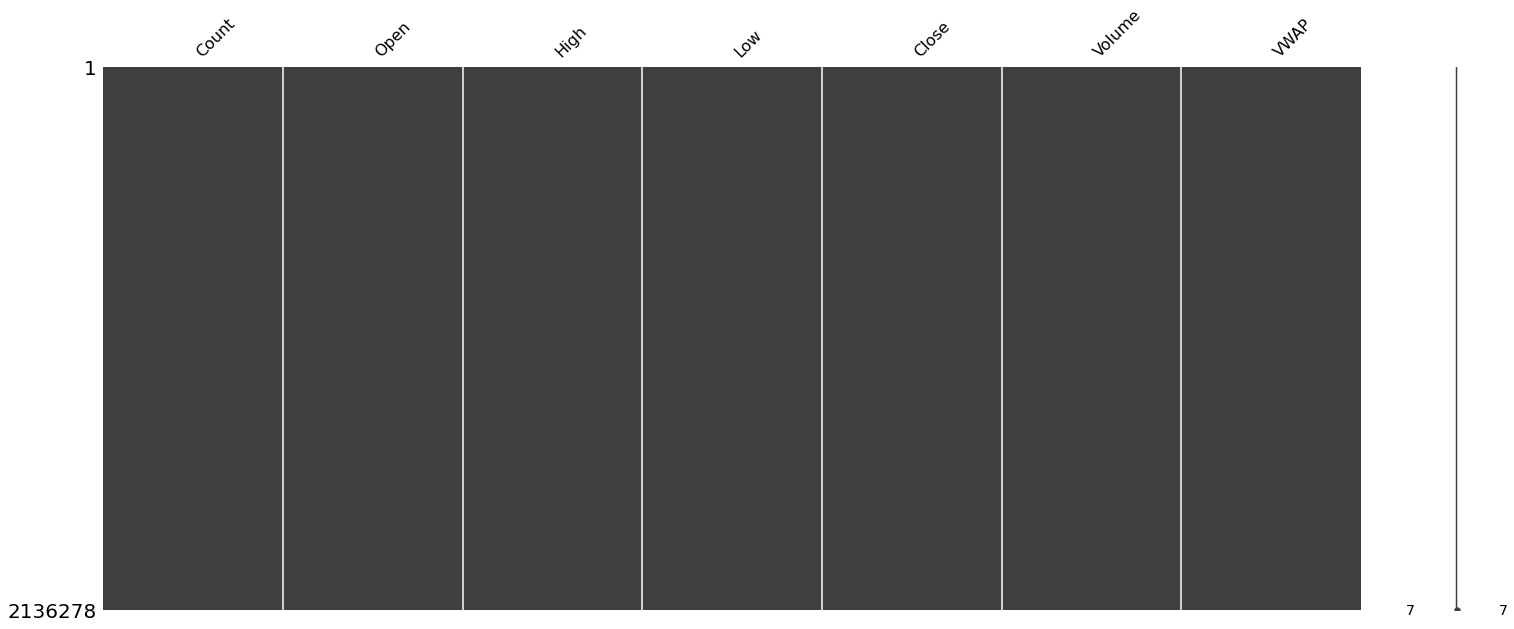

In [357]:
# Checking the NaN values distribution
_ = msn.matrix(df_dict[get_asset_id("Bitcoin")])

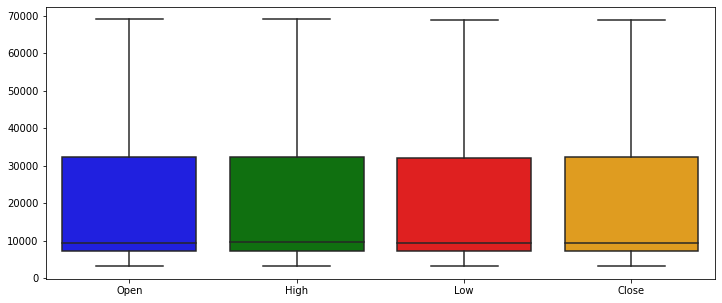

In [358]:
sns.boxplot(data=df_dict[get_asset_id("Bitcoin")][OHLC], showfliers=True);

# Bitcoin price movement prediction

## Data pre-processing

In [359]:
df_btc = df_dict[get_asset_id("Bitcoin")]

In [360]:
df_btc.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


TODO:
- Add explanation on target/close price movement
- Why we choose the Close price $\longrightarrow$ "The last transation price is the simplest definition of the price of a financial asset."

In [361]:
# Defining the target variable
df_btc["Target"] = np.where(df_btc["Close"].shift(-1) > df_btc["Close"], 1, 0)

In [362]:
df_btc

,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,
2018-01-01 00:01:00,229.0,13835.194000,14013.8,13666.11,13850.176000,31.550062,13827.062093,0
2018-01-01 00:02:00,235.0,13835.036000,14052.3,13680.00,13828.102000,31.046432,13840.362591,0
2018-01-01 00:03:00,528.0,13823.900000,14000.4,13601.00,13801.314000,55.061820,13806.068014,0
2018-01-01 00:04:00,435.0,13802.512000,13999.0,13576.28,13768.040000,38.780529,13783.598101,0
2018-01-01 00:05:00,742.0,13766.000000,13955.9,13554.44,13724.914000,108.501637,13735.586842,0
...,...,...,...,...,...,...,...,...
2022-01-23 23:56:00,1221.0,36278.361667,36331.0,36249.00,36293.123333,30.247067,36289.796806,0
2022-01-23 23:57:00,1634.0,36289.681667,36328.0,36230.72,36261.708333,35.647000,36276.229399,1
2022-01-23 23:58:00,1570.0,36262.841667,36319.0,36230.30,36276.223333,49.867700,36274.441548,1


In [363]:
# Splitting the dataset into X/Y
# X = features, Y = target
X = df_btc.copy() # X as a deep copy for security reason
Y = X.pop("Target")

In [364]:
X.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [365]:
Y.head()

timestamp
2018-01-01 00:01:00    0
2018-01-01 00:02:00    0
2018-01-01 00:03:00    0
2018-01-01 00:04:00    0
2018-01-01 00:05:00    0
Name: Target, dtype: int64

In [366]:
# Splitting into Train/Test split
tss = TimeSeriesSplit(n_splits = 3)

# Retrieving X_train, X_test, Y_train & Y_test
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

In [367]:
X_train

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229.0,13835.194000,14013.8,13666.11,13850.176000,31.550062,13827.062093
2018-01-01 00:02:00,235.0,13835.036000,14052.3,13680.00,13828.102000,31.046432,13840.362591
2018-01-01 00:03:00,528.0,13823.900000,14000.4,13601.00,13801.314000,55.061820,13806.068014
2018-01-01 00:04:00,435.0,13802.512000,13999.0,13576.28,13768.040000,38.780529,13783.598101
2018-01-01 00:05:00,742.0,13766.000000,13955.9,13554.44,13724.914000,108.501637,13735.586842
...,...,...,...,...,...,...,...
2021-01-18 02:34:00,3971.0,35942.280000,35980.0,35806.39,35828.222857,117.819204,35879.060140
2021-01-18 02:35:00,3211.0,35664.910000,35904.0,34500.00,35651.209956,106.882001,35660.859150
2021-01-18 02:36:00,2509.0,35819.511429,35862.0,35771.00,35803.075714,83.633094,35811.293395


In [368]:
X_test

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2021-01-18 02:39:00,2253.0,35822.537143,35934.0,35806.60,35852.995714,84.762343,35858.398313
2021-01-18 02:40:00,1735.0,35849.415714,35912.0,35810.30,35874.985714,46.545962,35857.016658
2021-01-18 02:41:00,1524.0,35869.542857,35929.0,35826.37,35871.412412,55.691964,35862.753869
2021-01-18 02:42:00,1135.0,35869.262857,35936.0,35843.91,35889.624286,36.432007,35877.562847
2021-01-18 02:43:00,1281.0,35888.857143,35951.0,35857.40,35903.960000,34.816070,35895.228109
...,...,...,...,...,...,...,...
2022-01-23 23:56:00,1221.0,36278.361667,36331.0,36249.00,36293.123333,30.247067,36289.796806
2022-01-23 23:57:00,1634.0,36289.681667,36328.0,36230.72,36261.708333,35.647000,36276.229399
2022-01-23 23:58:00,1570.0,36262.841667,36319.0,36230.30,36276.223333,49.867700,36274.441548


In [369]:
Y_train

timestamp
2018-01-01 00:01:00    0
2018-01-01 00:02:00    0
2018-01-01 00:03:00    0
2018-01-01 00:04:00    0
2018-01-01 00:05:00    0
                      ..
2021-01-18 02:34:00    0
2021-01-18 02:35:00    1
2021-01-18 02:36:00    1
2021-01-18 02:37:00    1
2021-01-18 02:38:00    1
Name: Target, Length: 1602209, dtype: int64

In [370]:
Y_test

timestamp
2021-01-18 02:39:00    1
2021-01-18 02:40:00    0
2021-01-18 02:41:00    1
2021-01-18 02:42:00    1
2021-01-18 02:43:00    1
                      ..
2022-01-23 23:56:00    0
2022-01-23 23:57:00    1
2022-01-23 23:58:00    1
2022-01-23 23:59:00    0
2022-01-24 00:00:00    0
Name: Target, Length: 534069, dtype: int64

## Prediction of the price movement <span style="color:red">[ML methods]</span>

### Logistic regression <span style="background:magenta; padding: 4px 6px">BASELINE</span>

In [371]:
from sklearn.linear_model import LogisticRegression

In [372]:
# Defining the classifier
clf = LogisticRegression()

In [373]:
# Fitting the data with the classifier
clf.fit(X_train, Y_train)

LogisticRegression()

In [374]:
# Making prediction based on samples within X_test
Y_pred = clf.predict(X_test)

In [375]:
Y_prob = clf.predict_proba(X_test)

In [376]:
assert np.all(np.unique(Y_pred) == np.array([0, 1]))

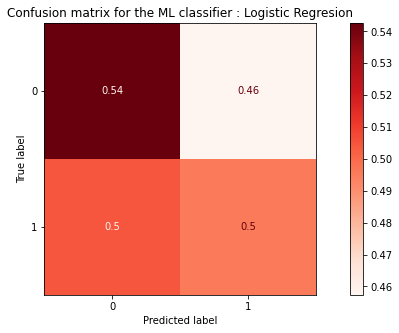

In [377]:
# Generate confusion matrix
matrix = plot_confusion_matrix(clf, 
                               X_test, Y_test,
                               cmap=plt.cm.Reds,
                               normalize='true')
_ = plt.title('Confusion matrix for the ML classifier : Logistic Regresion')

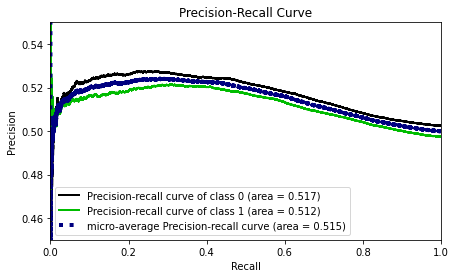

In [378]:
# Plotting Precision-Recall curve
fig, ax = plt.subplots(figsize=(7, 4))
_ = skplt.metrics.plot_precision_recall(Y_test, Y_prob, ax=ax)
_ = plt.ylim([0.45, 0.55])

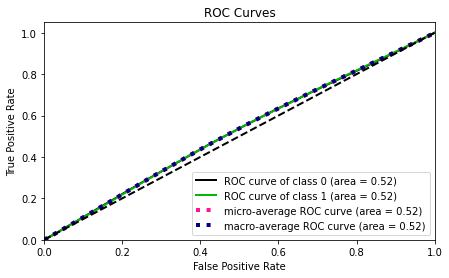

In [379]:
# Plotting ROC curve
fig, ax = plt.subplots(figsize=(7, 4))
_ = skplt.metrics.plot_roc_curve(Y_test, Y_prob, ax=ax)

### KNN

In [380]:
from sklearn.neighbors import KNeighborsClassifier

In [381]:
# Defining the classifier
clf = KNeighborsClassifier(n_neighbors=4)

In [382]:
# Fitting the data with the classifier
clf.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=4)

In [383]:
# Making prediction based on samples within X_test
Y_pred = clf.predict(X_test)

In [384]:
from sklearn.metrics import accuracy_score

# Getting the accuracy score of the model
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5021354918559212


In [385]:
import plotly.graph_objects as go

# Implementing a first trading algorithm using a fixed transaction cost
def trading_algorithm(Y_pred, X_test, transaction_cost=0.005, candlestick_chart = False, candlestick_chart_daily = False):
    shares = 0
    cash = 100000
    pnl = []
    buy_signals = []
    sell_signals = []
    
    for i in range(len(Y_pred)):  # looping through each prediction in Y_pred
        # if (prediction is 1) and (we don't have any shares) then buy 1 share
        if Y_pred[i] == 1 and shares == 0:
            shares += 1
            cost = X_test["Close"].iloc[i] * (1 + transaction_cost)
            cash -= cost
            buy_signals.append(i)
        # if (prediction is 0) and (we have shares) then sell 1 share
        elif Y_pred[i] == 0 and shares > 0:
            shares -= 1
            revenue = X_test["Close"].iloc[i] * (1 - transaction_cost)
            cash += revenue
            sell_signals.append(i)
        # if (prediction is 1) and (we already have shares) then continue to hold
        elif Y_pred[i] == 1 and shares > 0:
            continue
        
        pnl.append(shares * X_test["Close"].iloc[i] + cash)  # append the PnL to the PnL list
    
    # Plot the PnL
    plt.plot(pnl)
    plt.xlabel("Time")
    plt.ylabel("PnL")
    plt.title("Trading Algorithm PnL")
    plt.show()
    
    if (candlestick_chart):
        
        if (candlestick_chart_daily):
            # Resample data to daily frequency
            X_test_plot = X_test.resample('D').agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last'})
            # Plot a daily candlestick chart with buy and sell markers
            fig = go.Figure()

            fig.add_trace(go.Candlestick(x=X_test_plot.index,
                                         open=X_test_plot['Open'],
                                         high=X_test_plot['High'],
                                         low=X_test_plot['Low'],
                                         close=X_test_plot['Close'],
                                         name='Market Data'))

            fig.update_layout(title='Daily Candlestick Chart',
                              yaxis=dict(title='Price'),
                              xaxis=dict(title='Date'))

            fig.show()
            
        else:
            # Plot a candlestick chart with buy and sell markers
            # Please note that plotly may experience performance issues or crashes when handling large input datasets. 
            # If you encounter any issues, you may need to reduce the size of your input data or use data downsampling techniques to improve performance.
            print("Please note that plotly may experience performance issues or crashes when handling large input datasets. If you encounter any issues, you may need to reduce the size of your input data or use data downsampling techniques to improve performance.")
            fig = go.Figure()

            fig.add_trace(go.Candlestick(x=X_test.index,
                                         open=X_test['Open'],
                                         high=X_test['High'],
                                         low=X_test['Low'],
                                         close=X_test['Close'],
                                         name='Market Data'))

            fig.add_trace(go.Scatter(x=X_test.iloc[buy_signals].index,
                                     y=X_test.iloc[buy_signals]['Close'],
                                     mode='markers',
                                     marker=dict(symbol='circle', size=10, color='green'),
                                     name='Buy Signals'))

            fig.add_trace(go.Scatter(x=X_test.iloc[sell_signals].index,
                                     y=X_test.iloc[sell_signals]['Close'],
                                     mode='markers',
                                     marker=dict(symbol='circle', size=10, color='red'),
                                     name='Sell Signals'))

            fig.update_layout(title='Trading Algorithm with Buy and Sell signals',
                              yaxis=dict(title='Price'),
                              xaxis=dict(title='Date'))

            fig.show()

    return

In [386]:
# Testing trading_algorithm

# Full data + no candlestick chart plot
print('Full data + no candlestick chart plot:')
trading_algorithm(Y_pred, X_test)’

# Full data + daily candlestick chart plot
print('Full data + daily candlestick chart plot:')
trading_algorithm(Y_pred, X_test, candlestick_chart = True, candlestick_chart_daily = True)

# Small subset of data + full candlestick chart plot
print('Small subset of data + full candlestick chart plot:')
trading_algorithm(Y_pred[:100], X_test[:100], candlestick_chart = True)

SyntaxError: invalid character in identifier (<ipython-input-386-875128454569>, line 5)

In [ ]:
Y_prob = clf.predict_proba(X_test)

In [ ]:
assert np.all(np.unique(Y_pred) == np.array([0, 1]))

In [ ]:
# Generate confusion matrix
matrix = plot_confusion_matrix(clf, 
                               X_test, Y_test,
                               cmap=plt.cm.Reds,
                               normalize="true")
_ = plt.title('Confusion matrix for the ML classifier : KNN')

In [ ]:
# Plotting Precision-Recall curve
fig, ax = plt.subplots(figsize=(7, 4))
_ = skplt.metrics.plot_precision_recall(Y_test, Y_prob, ax=ax)
_ = plt.ylim([0.45, 1])

In [ ]:
# Plotting ROC curve
fig, ax = plt.subplots(figsize=(7, 4))
_ = skplt.metrics.plot_roc_curve(Y_test, Y_prob, ax=ax)

### Random Forest

## Prediction of the price movement <span style="color:red">[DL methods]</span>

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


In [ ]:
df_lstm=df_btc.resample('1h').agg({'Count': 'mean','Open':'first', 'High':'max', 'Low':'last', 'Close':'last','Volume':'mean','VWAP':'mean','Target':'last'})
df_lstm=df_lstm.loc[:'2018-05-31']
del df_lstm["Target"]    
df_lstm["Target"] = np.where(df_lstm["Close"].shift(-1) > df_lstm["Close"], 1, 0)
df_lstm

In [ ]:
X_lstm = df_lstm.copy() # X as a deep copy for security reason
Y_lstm = X_lstm.pop("Target")

In [ ]:
# Splitting into Train/Test split
tss = TimeSeriesSplit(n_splits = 3)

# Retrieving X_train, X_test, Y_train & Y_test
for train_index, test_index in tss.split(X_lstm):
    X_train_lstm, X_test_lstm = X_lstm.iloc[train_index, :], X_lstm.iloc[test_index,:]
    Y_train_lstm, Y_test_lstm = Y_lstm.iloc[train_index], Y_lstm.iloc[test_index]

In [ ]:
X_train_lstm, Y_train_lstm = np.array(X_train_lstm), np.array(Y_train_lstm)
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

In [ ]:
model = Sequential()

model.add(LSTM(32, activation='tanh',input_shape=(X_train_lstm.shape[1],1)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fitting the RNN to the Training set
model.fit(X_train_lstm, Y_train_lstm, epochs = 100, batch_size = 32)

In [ ]:
X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [ ]:
Y_pred_lstm = model.predict(X_test_lstm)
Y_pred_lstm=np.transpose(Y_pred_lstm)[0]
Y_pred_lstm = (Y_pred_lstm >= 0.5).astype(int)
Y_pred_lstm=np.array(Y_pred_lstm)

In [ ]:
from sklearn.metrics import accuracy_score

# Getting the accuracy score of the model
accuracy = accuracy_score(Y_test_lstm, Y_pred_lstm)
print("Accuracy:", accuracy)

In [ ]:
# Splitting into Train/Test split
tss = TimeSeriesSplit(n_splits = 3)

# Retrieving X_train, X_test, Y_train & Y_test
for train_index, test_index in tss.split(X_lstm):
    X_train_lstm, X_test_lstm = X_lstm.iloc[train_index, :], X_lstm.iloc[test_index,:]
    Y_train_lstm, Y_test_lstm = Y_lstm.iloc[train_index], Y_lstm.iloc[test_index]

In [ ]:
# Testing trading_algorithm

# Full data + no candlestick chart plot
print('Full data + no candlestick chart plot:')
trading_algorithm(Y_pred_lstm, X_test_lstm)

# Full data + daily candlestick chart plot
print('Full data + daily candlestick chart plot:')
trading_algorithm(Y_pred_lstm, X_test_lstm, candlestick_chart = True, candlestick_chart_daily = True)

# Small subset of data + full candlestick chart plot
print('Small subset of data + full candlestick chart plot:')
trading_algorithm(Y_pred_lstm[:100], X_test_lstm[:100], candlestick_chart = True)

## Transfer learning for other crypto-currencies 

# Conclusion

---

**Arian NAJAFY ABRANDABADY - Lucas RODRIGUEZ - Bastien TRIDON**